<a href="https://colab.research.google.com/github/athabrani/DeepLearning/blob/main/DeteksiSarkasme_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install -q -U keras-tuner

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import requests
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\athallah\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/06.%20Week%206/Datasets/DeteksiSarkasme.json"
df = pd.read_json(url, lines=True)
df = df[['headline', 'is_sarcastic']]
df.columns = ['headline', 'label']

In [75]:
df.head()

,headline,label
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [15]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['processed'] = df['headline'].apply(preprocess_text)

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['processed'])

# Tampilkan contoh data
print("\nExample sarcastic headline:")
print(df[df['label'] == 1]['headline'].iloc[0])  # label == 1 artinya sarkasme

print("\nExample non-sarcastic headline:")
print(df[df['label'] == 0]['headline'].iloc[0])  # label == 0 artinya tidak sarkasme

# Konversi ke sequence
sequences = tokenizer.texts_to_sequences(df['processed'])
X = pad_sequences(sequences, padding='post')
y = df['label'].values

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Info dimensi
maxlen = X.shape[1]
vocab_size = len(tokenizer.word_index) + 1

print(f"\n Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Vocab size: {vocab_size}")
print(f"Max sequence length: {maxlen}")


Example sarcastic headline:
mom starting to fear son's web series closest thing she will have to grandchild

Example non-sarcastic headline:
former versace store clerk sues over secret 'black code' for minority shoppers

 Training set size: 21367
Test set size: 5342
Vocab size: 28420
Max sequence length: 39


#RNN Model

In [78]:
def build_model(hp):
    model = keras.Sequential()

    # Embedding layer
    embedding_dim = hp.Int('embedding_dim', min_value=32, max_value=512, step=32)
    model.add(layers.Embedding(input_dim=vocab_size,
                               output_dim=embedding_dim,
                               input_length=maxlen))

    # Dropout for regularization
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    model.add(layers.Dropout(dropout_rate))

    # RNN Layer
    rnn_units = hp.Int('rnn_units', min_value=32, max_value=256, step=32)
    model.add(layers.SimpleRNN(rnn_units))

    # Dense layers
    dense_units = hp.Int('dense_units', min_value=16, max_value=128, step=16)
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dropout(dropout_rate))

    # Output
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [70]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='keras_tuner_dir',
    project_name='sarcasm_rnn'
)

stop_early = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

tuner.search(
    X_train, y_train,
    epochs=10,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=1
)

# Get best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(" Best Hyperparameters:")
print(f"- Embedding Dimension: {best_hps.get('embedding_dim')}")
print(f"- RNN Units: {best_hps.get('rnn_units')}")
print(f"- Dense Units: {best_hps.get('dense_units')}")
print(f"- Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"- Learning Rate: {best_hps.get('learning_rate')}")


Trial 30 Complete [00h 06m 53s]
val_accuracy: 0.5538137555122375

Best val_accuracy So Far: 0.8551707863807678
Total elapsed time: 01h 53m 54s
 Best Hyperparameters:
- Embedding Dimension: 32
- RNN Units: 64
- Dense Units: 32
- Dropout Rate: 0.2
- Learning Rate: 0.00018680116887932784


In [71]:
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train, y_train,
    epochs=15,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=1
)

Epoch 1/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.5883 - loss: 0.6569 - val_accuracy: 0.7904 - val_loss: 0.4567
Epoch 2/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.8495 - loss: 0.3709 - val_accuracy: 0.8205 - val_loss: 0.4214
Epoch 3/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9184 - loss: 0.2198 - val_accuracy: 0.8407 - val_loss: 0.4046
Epoch 4/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.9552 - loss: 0.1380 - val_accuracy: 0.8355 - val_loss: 0.4574
Epoch 5/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.9721 - loss: 0.0881 - val_accuracy: 0.8358 - val_loss: 0.5401
Epoch 6/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.9817 - loss: 0.0604 - val_accuracy: 0.8320 - val_loss: 0.5825


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

📊 Final Evaluation on Test Set:
Accuracy : 0.8385
Precision: 0.8354
Recall   : 0.7873
F1 Score : 0.8106
AUC      : 0.9164


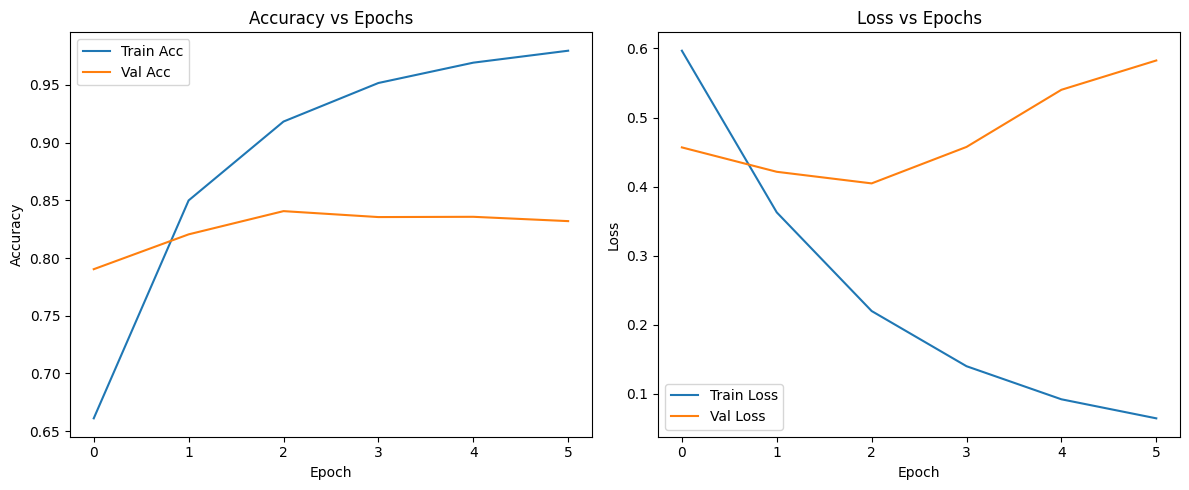

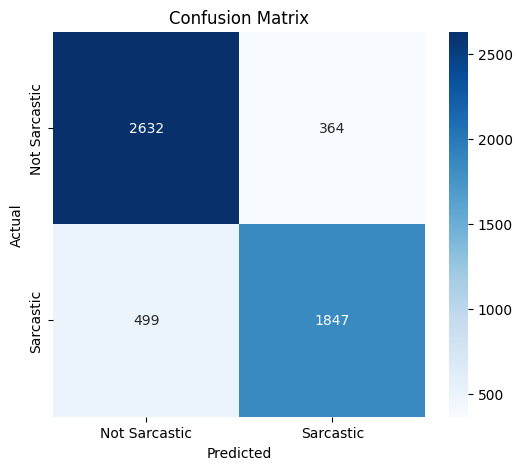

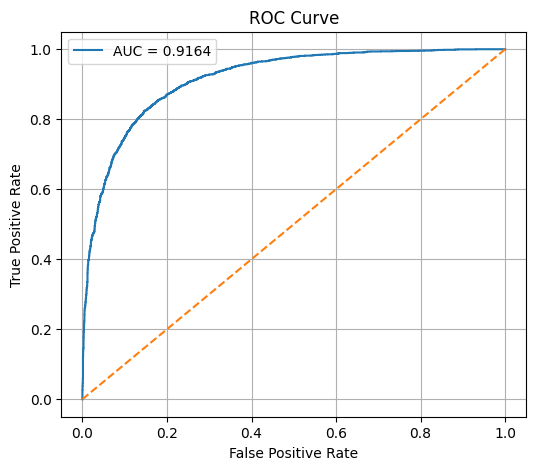

In [72]:
y_prob = best_model.predict(X_test).flatten()
y_pred = (y_prob >= 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

print("\n Final Evaluation on Test Set:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")


plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Sarcastic', 'Sarcastic'],
            yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

#LSTM Model

In [84]:
def build_lstm_model(hp):
    """Build a LSTM model with hyperparameters to be tuned"""
    model = Sequential()

    # Embedding layer
    embedding_dim = hp.Int('embedding_dim', min_value=32, max_value=1024, step=32)
    model.add(layers.Embedding(input_dim=vocab_size,
                               output_dim=embedding_dim,
                               input_length=maxlen))

    # Dropout for regularization
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    model.add(layers.Dropout(dropout_rate))

    # LSTM layer
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=1024, step=32)
    model.add(layers.LSTM(lstm_units))

    # Dense layers
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=16, max_value=128, step=16),
        activation='relu'
    ))
    model.add(layers.Dropout(dropout_rate))

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

Hyperparameters Tuning

In [85]:
tuner_lstm = kt.Hyperband(
    build_lstm_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=4,
    directory='keras_tuner',
    project_name='sarcasm_lstm_detection'
)

stop_early = EarlyStopping(monitor='val_accuracy', patience=3)

# Search for the best hyperparameters
tuner_lstm.search(
    X_train, y_train,
    epochs=10,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=1
)

# Get the best hyperparameters
best_hps_lstm = tuner_lstm.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters for LSTM:")
print(f"- Embedding Dimension: {best_hps_lstm.get('embedding_dim')}")
print(f"- LSTM Units: {best_hps_lstm.get('lstm_units')}")
print(f"- Dense Units: {best_hps_lstm.get('dense_units')}")
print(f"- Dropout Rate: {best_hps_lstm.get('dropout_rate')}")
print(f"- Learning Rate: {best_hps_lstm.get('learning_rate')}")

Trial 11 Complete [00h 19m 50s]
val_accuracy: 0.5538137555122375

Best val_accuracy So Far: 0.8465138077735901
Total elapsed time: 03h 05m 46s
Best Hyperparameters for LSTM:
- Embedding Dimension: 512
- LSTM Units: 416
- Dense Units: 16
- Dropout Rate: 0.2
- Learning Rate: 0.00021893220837161223


Epoch 1/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 339s 625ms/step - accuracy: 0.5616 - loss: 0.6882 - val_accuracy: 0.5538 - val_loss: 0.6846
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 383s 627ms/step - accuracy: 0.7210 - loss: 0.5645 - val_accuracy: 0.7403 - val_loss: 0.5546
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 373s 611ms/step - accuracy: 0.6844 - loss: 0.5809 - val_accuracy: 0.5538 - val_loss: 0.6874
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 390s 627ms/step - accuracy: 0.5790 - loss: 0.6770 - val_accuracy: 0.5557 - val_loss: 0.5908
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 380s 624ms/step - accuracy: 0.7587 - loss: 0.4622 - val_accuracy: 0.8182 - val_loss: 0.4315
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 378s 617ms/step - accuracy: 0.9201 - loss: 0.2529 - val_accuracy: 0.8241 - val_loss: 0.4613
Epoch 7/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 389s 630ms/step - accuracy: 0.9492 - loss: 0.1780 - val_accuracy: 0.8182 - val_loss: 0.5274
Epoch 8/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 378s 623ms/step - accuracy: 0.9697 -

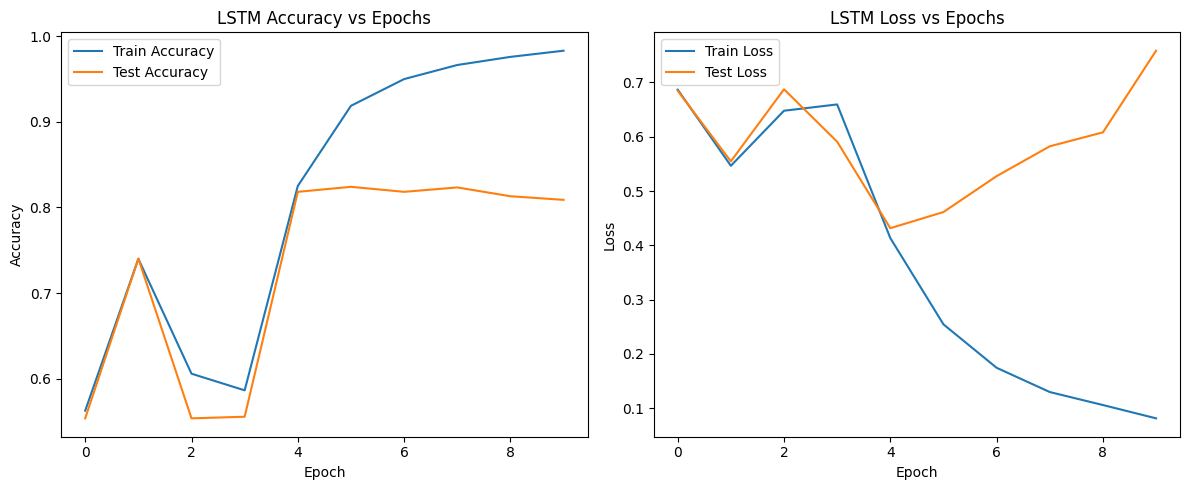

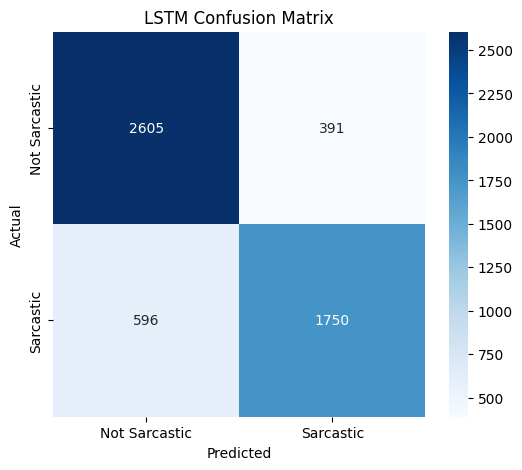

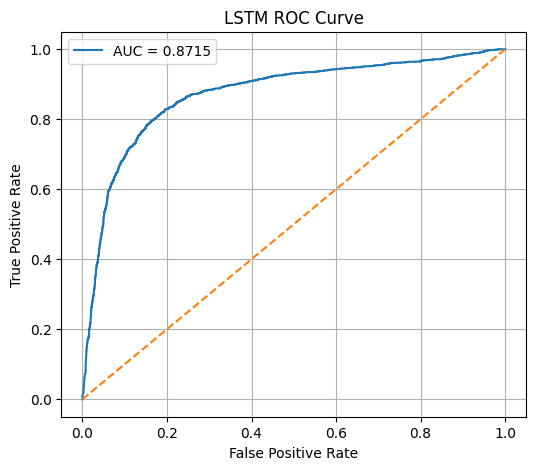

In [86]:
best_lstm_model = tuner_lstm.hypermodel.build(best_hps_lstm)

# Train the LSTM model
history_lstm = best_lstm_model.fit(
    X_train, y_train,
    epochs=10,
    validation_split=0.2,
    verbose=1
)

# Evaluate the LSTM model
y_prob_lstm = best_lstm_model.predict(X_test).flatten()
y_pred_lstm = (y_prob_lstm >= 0.5).astype(int)

# Metrics
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
precision_lstm = precision_score(y_test, y_pred_lstm)
recall_lstm = recall_score(y_test, y_pred_lstm)
f1_lstm = f1_score(y_test, y_pred_lstm)
auc_lstm = roc_auc_score(y_test, y_prob_lstm)

print(f"\nFinal Evaluation on Test Set (LSTM):")
print(f"Accuracy : {accuracy_lstm:.4f}")
print(f"Precision: {precision_lstm:.4f}")
print(f"Recall   : {recall_lstm:.4f}")
print(f"F1 Score : {f1_lstm:.4f}")
print(f"AUC      : {auc_lstm:.4f}")

# Plot training history (LSTM)
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('LSTM Accuracy vs Epochs')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Loss vs Epochs')

plt.tight_layout()
plt.show()

# Confusion Matrix (LSTM)
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Sarcastic', 'Sarcastic'],
            yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LSTM Confusion Matrix')
plt.show()

# ROC Curve (LSTM)
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_prob_lstm)
plt.figure(figsize=(6, 5))
plt.plot(fpr_lstm, tpr_lstm, label=f"AUC = {auc_lstm:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LSTM ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

#GRU Model

In [17]:
def build_gru_model(hp, vocab_size, maxlen):
    model = Sequential()

    embedding_dim = hp.Int('embedding_dim', min_value=64, max_value=512, step=64)
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
    model.add(layers.SpatialDropout1D(hp.Float('embedding_dropout', 0.1, 0.5, step=0.1)))

    gru_units = hp.Int('gru_units', 64, 512, step=64)
    model.add(layers.Bidirectional(layers.GRU(gru_units, return_sequences=True)))
    model.add(layers.BatchNormalization())
    model.add(layers.GRU(gru_units))

    dense_units = hp.Int('dense_units', 32, 128, step=32)
    dropout_rate = hp.Float('dropout_rate', 0.2, 0.5, step=0.1)
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(1, activation='sigmoid'))

    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


Hyperparameters Tuning

In [18]:
class GRUHyperModel(kt.HyperModel):
    def __init__(self, vocab_size, maxlen):
        self.vocab_size = vocab_size
        self.maxlen = maxlen

    def build(self, hp):
        return build_gru_model(hp, self.vocab_size, self.maxlen)


In [19]:
hypermodel = GRUHyperModel(vocab_size=vocab_size, maxlen=maxlen)

tuner = kt.Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=15,
    factor=3,
    directory='keras_tuner',
    project_name='gru_sarcasm'
)

stop_early = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6)

tuner.search(X_train, y_train,
             epochs=10,
             validation_split=0.2,
             callbacks=[stop_early, reduce_lr],
             verbose=1)
best_model = tuner.hypermodel.build(tuner.get_best_hyperparameters(1)[0])
best_model.save('best_gru_sarcasm_model.h5')


Trial 30 Complete [00h 15m 48s]
val_accuracy: 0.5538137555122375

Best val_accuracy So Far: 0.8514272570610046
Total elapsed time: 03h 55m 00s


In [21]:
history = best_model.fit(
    X_train, y_train,
    epochs=10,
    validation_split=0.2,
    callbacks=[stop_early, reduce_lr],
    verbose=1
)


Epoch 1/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 190s 347ms/step - accuracy: 0.5458 - loss: 0.6967 - val_accuracy: 0.5538 - val_loss: 0.6881 - learning_rate: 3.9368e-04
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 188s 352ms/step - accuracy: 0.5585 - loss: 0.6880 - val_accuracy: 0.5538 - val_loss: 0.6875 - learning_rate: 3.9368e-04
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 187s 349ms/step - accuracy: 0.5602 - loss: 0.6873 - val_accuracy: 0.5538 - val_loss: 0.6873 - learning_rate: 3.9368e-04
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 172s 321ms/step - accuracy: 0.5557 - loss: 0.6873 - val_accuracy: 0.5538 - val_loss: 0.6809 - learning_rate: 3.9368e-04
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 164s 307ms/step - accuracy: 0.7754 - loss: 0.4652 - val_accuracy: 0.8276 - val_loss: 0.3592 - learning_rate: 3.9368e-04
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 182s 340ms/step - accuracy: 0.9437 - loss: 0.1590 - val_accuracy: 0.8418 - val_loss: 0.3899 - learning_rate: 3.9368e-04
Epoch 7/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 

In [22]:
# Predict Probabilitas
y_prob = best_model.predict(X_test).flatten()

# Cari Threshold Optimal
thresholds = np.arange(0.3, 0.7, 0.01)
best_thresh, best_f1 = 0.5, 0
for t in thresholds:
    f1 = f1_score(y_test, (y_prob >= t).astype(int))
    if f1 > best_f1:
        best_thresh, best_f1 = t, f1

print(f"Optimal Threshold: {best_thresh:.2f}")

# Final Predict
y_pred = (y_prob >= best_thresh).astype(int)

# Skor
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(f"\nEvaluation on Test Set:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")


167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step
Optimal Threshold: 0.30

Evaluation on Test Set:
Accuracy : 0.8581
Precision: 0.8393
Recall   : 0.8372
F1 Score : 0.8382
AUC      : 0.9350


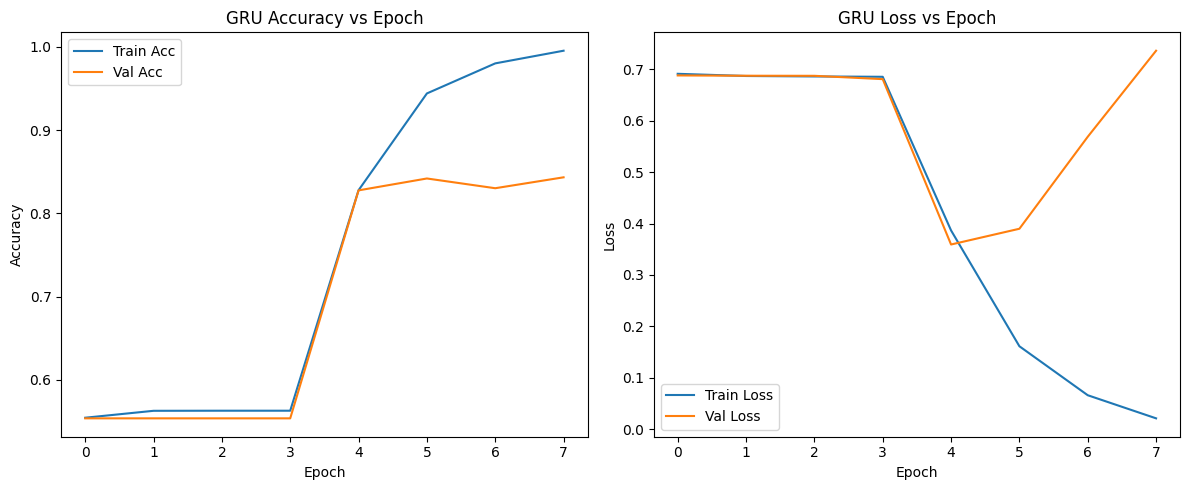

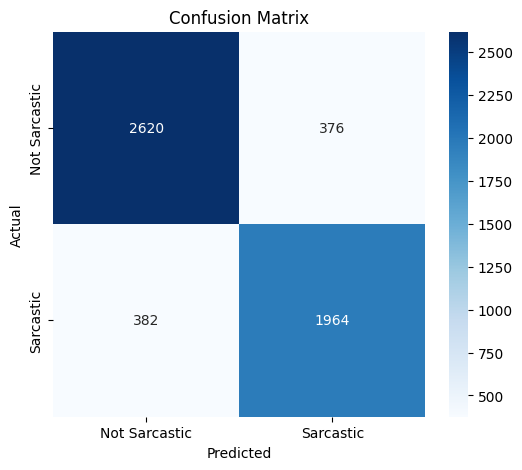

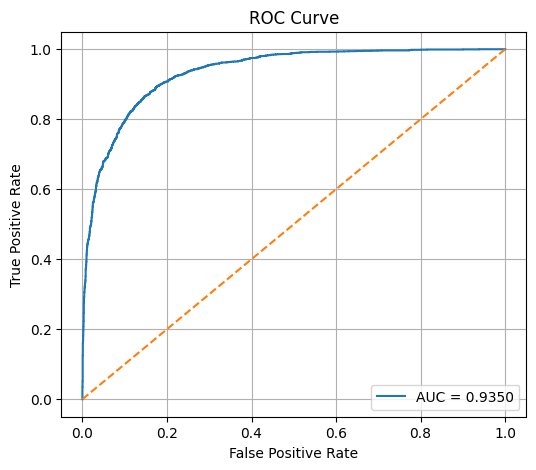

In [23]:
# History
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('GRU Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('GRU Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Sarcastic', 'Sarcastic'],
            yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


# Penjelasan Model, Visualisasi, dan Metrik

## 1. RNN (Recurrent Neural Network)

RNN menggunakan mekanisme *recurrence* untuk memproses data sekuensial seperti teks.

### Persamaan Dasar

**State Update**:

$$
h_t = \phi(W_{hh}h_{t-1} + W_{xh}x_t + b_h)
$$

### Penjelasan

- \( h_t \): State tersembunyi pada waktu \( t \)  
- \( x_t \): Input pada waktu \( t \)  
- \( W_{hh}, W_{xh} \): Matriks bobot untuk state sebelumnya dan input saat ini  
- \( b_h \): Bias  
- \( \phi \): Fungsi aktivasi (contoh: tanh atau ReLU)

---

## 2. LSTM (Long Short-Term Memory)

LSTM mengatasi masalah *vanishing gradient* pada RNN dengan mekanisme *gate*.

### Persamaan Dasar

**Forget Gate**:

$$
f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
$$

**Input Gate**:

$$
i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) \\
\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)
$$

**Cell State Update**:

$$
C_t = f_t * C_{t-1} + i_t * \tilde{C}_t
$$

**Output Gate**:

$$
o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) \\
h_t = o_t * \tanh(C_t)
$$

---

## 3. GRU (Gated Recurrent Unit)

GRU menyederhanakan LSTM dengan menggabungkan *forget* dan *input gate*.

### Persamaan Dasar

**Reset Gate**:

$$
r_t = \sigma(W_r \cdot [h_{t-1}, x_t])
$$

**Update Gate**:

$$
z_t = \sigma(W_z \cdot [h_{t-1}, x_t])
$$

**State Update**:

$$
\tilde{h}_t = \tanh(W \cdot [r_t * h_{t-1}, x_t]) \\
h_t = (1 - z_t) * h_{t-1} + z_t * \tilde{h}_t
$$

---

## 4. Visualisasi

### Akurasi

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

### Loss (Binary Cross-Entropy)

$$
\mathcal{L}(y, \hat{y}) = -\left[y \log(\hat{y}) + (1 - y) \log(1 - \hat{y})\right]
$$

### ROC Curve

- **True Positive Rate (TPR)**:
  $$
  \text{TPR} = \frac{TP}{TP + FN}
  $$

- **False Positive Rate (FPR)**:
  $$
  \text{FPR} = \frac{FP}{FP + TN}
  $$

### AUC (Area Under Curve)

AUC mengukur kualitas pemisahan prediksi; nilai mendekati 1 menunjukkan performa sangat baik.

---

## 5. Metrik Evaluasi

### Precision

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

### Recall

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

### F1 Score

$$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

---

# Analisis Hasil Model

### RNN

- **Accuracy**: 0.8385  
- **Precision**: 0.8354  
- **Recall**: 0.7873  
- **F1 Score**: 0.8106  
- **AUC**: 0.9164  

**Analisis**:  
Model RNN memiliki performa cukup tinggi, dengan keseimbangan antara precision dan recall. AUC menunjukkan pemisahan kelas yang sangat baik. Namun, F1 Score yang sedikit lebih rendah mengindikasikan adanya trade-off antara false positive dan false negative.

---

### LSTM

- **Accuracy**: 0.8152  
- **Precision**: 0.8174  
- **Recall**: 0.7460  
- **F1 Score**: 0.7800  
- **AUC**: 0.8715  

**Analisis**:  
LSTM sedikit tertinggal dibanding RNN dalam metrik evaluasi. Meskipun secara teori unggul dalam menangkap dependensi jangka panjang, hasil menunjukkan bahwa konfigurasi saat ini masih dapat dioptimalkan, terutama dari segi recall.

---

### GRU

- **Accuracy**: 0.8581  
- **Precision**: 0.8393  
- **Recall**: 0.8372  
- **F1 Score**: 0.8382  
- **AUC**: 0.9350  

**Analisis**:  
Model GRU menunjukkan performa terbaik di antara ketiganya. Dengan precision dan recall yang seimbang serta nilai AUC tertinggi, GRU mampu menangkap pola sekuensial dengan efisien dan menghasilkan prediksi yang sangat akurat.

---

# Penjelasan Matematika PyTorch

## 1. Embedding Layer

```python
nn.Embedding(num_embeddings, embedding_dim)
```

- Input: Tensor dengan dimensi \( (batch\_size, sequence\_length) \)  
- Matriks bobot: \( (vocab\_size, embedding\_dim) \)  
- Output: Tensor dengan dimensi \( (batch\_size, sequence\_length, embedding\_dim) \)

---

## 2. RNN, GRU, LSTM

### a. RNN (nn.RNN)

$$
h_t = \tanh(W_{ih} x_t + b_{ih} + W_{hh} h_{t-1} + b_{hh})
$$

### b. GRU (nn.GRU)

- Otomatis menghitung reset gate, update gate, dan state update.
- Menghindari eksplisit cell state seperti pada LSTM.

### c. LSTM (nn.LSTM)

- Mengelola \( h_t \) dan \( C_t \) secara otomatis.
- Mendukung multiple layer dan bidirectional setting.

---

## 3. Dropout (nn.Dropout)

$$
y = \frac{m * x}{1 - p}
$$

- \( m \): mask binari, \( p \): probabilitas dropout  
- Diaktifkan saat training, dinonaktifkan saat evaluasi

---

## 4. Fully Connected Layers (nn.Linear)

$$
y = W x + b
$$

- Diikuti oleh fungsi aktivasi seperti ReLU atau Sigmoid

---

## 5. Binary Cross-Entropy Loss (BCELoss)

$$
\mathcal{L} = -[y \cdot \log(\hat{y}) + (1 - y) \cdot \log(1 - \hat{y})]
$$

- \( y \): Label sebenarnya  
- \( \hat{y} \): Probabilitas keluaran dari sigmoid

---

## 6. GradScaler

- Mendukung mixed precision training  
- Mencegah overflow/underflow numerik pada float16

---

## 7. ReduceLROnPlateau

```python
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5)
```

- Mengurangi learning rate saat loss validasi stagnan

---

# Penyesuaian Hyperparameter dengan Keras-Tuner

## Algoritma Hyperband

- Mengelola eksplorasi dan eksploitasi dengan efisien  
- Uji coba awal banyak, lalu fokus ke konfigurasi terbaik

## Hyperparameter yang Disetel

1. **Embedding Dim**: `32 - 256`, langkah 32  
2. **LSTM Units**: `32 - 256`, langkah 32  
3. **Dense Units**: `16 - 128`, langkah 16  
4. **Dropout Rate**: `0.2 - 0.5`, langkah 0.1  
5. **Learning Rate**: `1e-4 - 1e-2` (log scale)

## Early Stopping

```python
EarlyStopping(monitor='val_accuracy', patience=3)
```

## Ekstraksi Hyperparameter Terbaik

```python
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
```

---

